In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [4]:
#import os
print(os.listdir("/gdrive/My Drive/Retinal Imaging/Eyes"))

data_dir = '/gdrive/My Drive/Retinal Imaging/Eyes'

img_height, img_width = 50, 50
data_path = "/gdrive/My Drive/Retinal Imaging/Eyes"
Cataract_path = os.path.join(data_path, "Cataract")
Diabetic_Retinopathy_path = os.path.join(data_path, "Diabetic Retinopathy")
Glaucoma_path = os.path.join(data_path, "Glaucoma")
Normal_path = os.path.join(data_path, "Normal")


['Normal', 'Diabetic Retinopathy', 'Glaucoma', 'Cataract']


In [21]:
def load_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Unable to read image {img_path}")
            continue
        img = cv2.resize(img, (img_height, img_width))
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

Cataract_images, Cataract_labels = load_images(Cataract_path, 0)
Diabetic_Retinopathy_images, Diabetic_Retinopathy_labels = load_images(Diabetic_Retinopathy_path, 1)
Glaucoma_images, Glaucoma_labels = load_images(Glaucoma_path, 2)
Normal_images, Normal_labels = load_images(Normal_path, 3)


x = np.concatenate((Cataract_images, Diabetic_Retinopathy_images, Glaucoma_images, Normal_images), axis=0)
y = np.concatenate((Cataract_labels, Diabetic_Retinopathy_labels, Glaucoma_labels, Normal_labels), axis=0)


**%35 ayırma**

In [22]:
# Veri setini ayırma
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [23]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [24]:
import tensorflow as tf

train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=4)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=4)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=4)

# **DenseNet121**

In [25]:
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten

input_layer = tf.keras.Input((img_width,img_height,3))
preprocessed_inputs = tf.keras.layers.Lambda( lambda x : preprocess_input(x))(input_layer)

base_model = DenseNet121(
    weights = "imagenet",
    include_top = False,
    input_tensor = preprocessed_inputs
)

k = GlobalAveragePooling2D()(base_model.output)
k = Dense(4)(k)

transfer_learning_model = tf.keras.Model(inputs = input_layer, outputs = k)

from tensorflow import keras

callback_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor = 'val_accuracy', save_best_only=True, verbose=3
    ),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=3)
]

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.1,
    patience = 3,
    mode = "min",
    verbose = 1,
    min_lr = 1e-8
)

callback_list.append(reduce_lr)

transfer_learning_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

#Modelimizi eğitiyoruz.
transfer_learning_model.fit(
            x_train,
            train_yCl,
            epochs = 10,
            batch_size = 64,
            validation_data = (x_val, valid_yCl),
            callbacks = callback_list
            )

Epoch 1/10
39/39 [==============================] - ETA: 0s - loss: 3.4411 - accuracy: 0.3285
Epoch 1: val_accuracy improved from -inf to 0.26182, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 64s 212ms/step - loss: 3.4411 - accuracy: 0.3285 - val_loss: 7.4653 - val_accuracy: 0.2618 - lr: 0.0010
Epoch 2/10
39/39 [==============================] - ETA: 0s - loss: 2.4099 - accuracy: 0.3779
Epoch 2: val_accuracy improved from 0.26182 to 0.28364, saving model to model.h5
39/39 [==============================] - 5s 116ms/step - loss: 2.4099 - accuracy: 0.3779 - val_loss: 7.3155 - val_accuracy: 0.2836 - lr: 0.0010
Epoch 3/10
39/39 [==============================] - ETA: 0s - loss: 2.2460 - accuracy: 0.4254
Epoch 3: val_accuracy improved from 0.28364 to 0.30182, saving model to model.h5
39/39 [==============================] - 6s 143ms/step - loss: 2.2460 - accuracy: 0.4254 - val_loss: 5.5600 - val_accuracy: 0.3018 - lr: 0.0010
Epoch 4/10
39/39 [==============================] - ETA: 0s - loss: 2.2772 - accuracy: 0.4404
Epoch 4: val_accuracy improved from 0.30182 to 0.39636, saving model to model.h5
39/39 [==============================] - 5

**Test verisi üzerinde DenseNet121 modelimizi değerlendirelim**

In [26]:
#Modelimizin Validation, Test ve Train Acurracy Skorlarını hesaplayalım.
score_valid = transfer_learning_model.evaluate(x_val, valid_yCl)
print("Validation Accuracy: ", score_valid[1])

score_test = transfer_learning_model.evaluate(x_test, test_yCl)
print("Validation Accuracy: ", score_test[1])

score_train = transfer_learning_model.evaluate(x_train, train_yCl)
print("Validation Accuracy: ", score_train[1])

# Test verisi üzerinde tahminlerin yapılması
y_pred = transfer_learning_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_yCl, axis=1)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Test Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(y_true, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_true, y_pred_classes, average='weighted')
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred_classes, labels=np.unique(y_true))
print('Classification Report:')
print(class_report)

9/9 [==============================] - 0s 22ms/step - loss: 2.3318 - accuracy: 0.4182
Validation Accuracy:  0.41818180680274963
47/47 [==============================] - 1s 16ms/step - loss: 2.3170 - accuracy: 0.4153
Validation Accuracy:  0.41531166434288025
78/78 [==============================] - 1s 13ms/step - loss: 2.3034 - accuracy: 0.4347
Validation Accuracy:  0.43471208214759827
47/47 [==============================] - 2s 14ms/step
Test Accuracy: 0.4153
Precision: 0.2683
Recall: 0.4153
F1 Score: 0.3022
Confusion Matrix:
[[  0  52 322   0]
 [  0 284 111   0]
 [  0  16 329   0]
 [  0  32 330   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       374
           1       0.74      0.72      0.73       395
           2       0.30      0.95      0.46       345
           3       0.00      0.00      0.00       362

    accuracy                           0.42      1476
   macro avg       0.26      0.42      0.3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

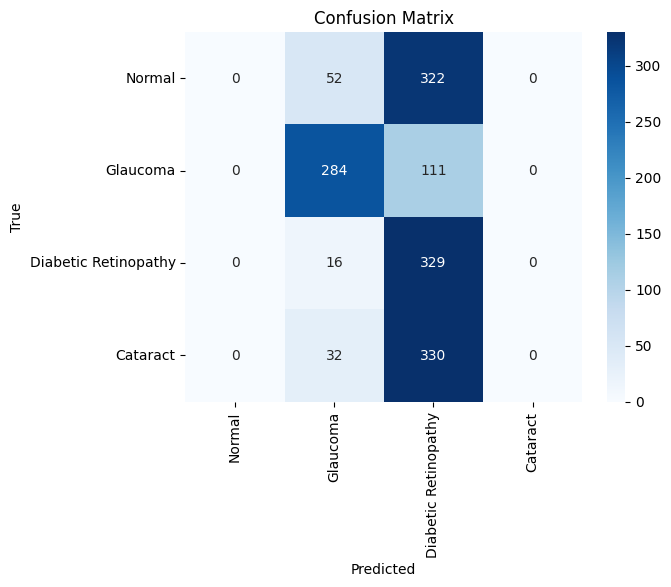

In [27]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Glaucoma","Diabetic Retinopathy","Cataract"], yticklabels=["Normal","Glaucoma","Diabetic Retinopathy","Cataract"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# **EfficientNetB0**

In [28]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(img_width, img_height, 3)
)

k = GlobalMaxPooling2D()(base_model.output)
k = Dense(4)(k)

transfer_learning_model_efficientnet = tf.keras.Model(inputs=base_model.input, outputs=k)

transfer_learning_model_efficientnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callback_list_efficientnet = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_efficientnet.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=3
    ),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=3)
]

transfer_learning_model_efficientnet.fit(
    x_train,
    train_yCl,
    epochs=10,
    batch_size=64,
    validation_data=(x_val, valid_yCl),
    callbacks=callback_list_efficientnet
)

Epoch 1/10
38/39 [============================>.] - ETA: 0s - loss: 5.4952 - accuracy: 0.2627
Epoch 1: val_accuracy improved from -inf to 0.23636, saving model to model_efficientnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 37s 112ms/step - loss: 5.4498 - accuracy: 0.2624 - val_loss: 7.4411 - val_accuracy: 0.2364
Epoch 2/10
39/39 [==============================] - ETA: 0s - loss: 4.0054 - accuracy: 0.3159
Epoch 2: val_accuracy improved from 0.23636 to 0.34545, saving model to model_efficientnet.h5
39/39 [==============================] - 4s 98ms/step - loss: 4.0054 - accuracy: 0.3159 - val_loss: 5.6702 - val_accuracy: 0.3455
Epoch 3/10
39/39 [==============================] - ETA: 0s - loss: 3.1050 - accuracy: 0.2737
Epoch 3: val_accuracy did not improve from 0.34545
39/39 [==============================] - 3s 64ms/step - loss: 3.1050 - accuracy: 0.2737 - val_loss: 4.7287 - val_accuracy: 0.2473
Epoch 4/10
39/39 [==============================] - ETA: 0s - loss: 2.9872 - accuracy: 0.2498
Epoch 4: val_accuracy did not improve from 0.34545
39/39 [==============================] - 2s 58ms/step - loss: 2.9872 - accuracy: 0.2498 - val_loss: 3.1752 - val_accuracy: 0.2036


**Test verisi üzerinde EfficientNetB0 modelimizi değerlendirelim**

In [29]:
score_valid = transfer_learning_model.evaluate(x_val, valid_yCl)
print("Validation Accuracy: ", score_valid[1])

score_test = transfer_learning_model.evaluate(x_test, test_yCl)
print("Validation Accuracy: ", score_test[1])

score_train = transfer_learning_model.evaluate(x_train, train_yCl)
print("Validation Accuracy: ", score_train[1])

# Test verisi üzerinde tahminlerin yapılması
y_pred = transfer_learning_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_yCl, axis=1)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Test Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(y_true, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_true, y_pred_classes, average='weighted')
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred_classes, labels=np.unique(y_true))
print('Classification Report:')
print(class_report)

9/9 [==============================] - 0s 23ms/step - loss: 2.3318 - accuracy: 0.4182
Validation Accuracy:  0.41818180680274963
47/47 [==============================] - 1s 15ms/step - loss: 2.3170 - accuracy: 0.4153
Validation Accuracy:  0.41531166434288025
78/78 [==============================] - 1s 13ms/step - loss: 2.3034 - accuracy: 0.4347
Validation Accuracy:  0.43471208214759827
47/47 [==============================] - 1s 12ms/step
Test Accuracy: 0.4153
Precision: 0.2683
Recall: 0.4153
F1 Score: 0.3022
Confusion Matrix:
[[  0  52 322   0]
 [  0 284 111   0]
 [  0  16 329   0]
 [  0  32 330   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       374
           1       0.74      0.72      0.73       395
           2       0.30      0.95      0.46       345
           3       0.00      0.00      0.00       362

    accuracy                           0.42      1476
   macro avg       0.26      0.42      0.3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

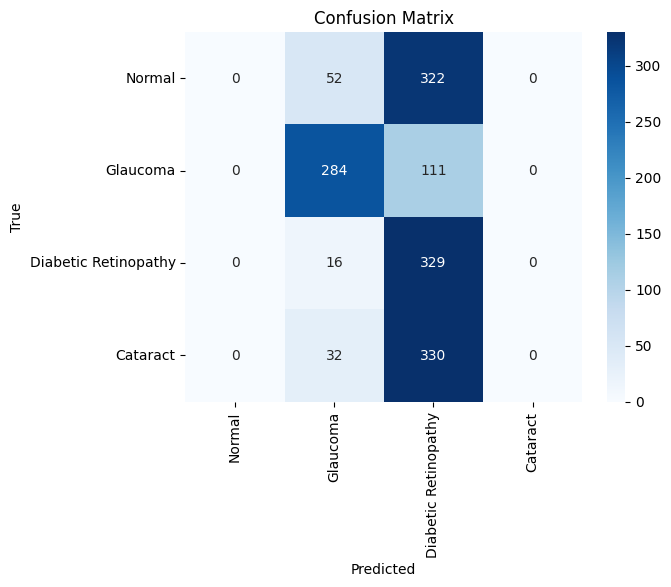

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Glaucoma","Diabetic Retinopathy","Cataract"], yticklabels=["Normal","Glaucoma","Diabetic Retinopathy","Cataract"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()